In [1]:
import numpy as np
from numpy import linalg as LA
import time
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2 #set the value globally
import time
import datetime
import os
import pandas as pd
from scipy.interpolate import interp1d
#import plotly.graph_objects as go
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size(32)

font_tick = FontProperties()
font_tick.set_family('serif')
font_tick.set_name('Times New Roman')
font_tick.set_size(22)


In [2]:
def Current_ScanRate (List_arq, List_Voltage_Values, Path_Arq_Raw):
    """
        Arguments:
        List_Arq = a 1-d list with the name of the files containing the I-V scan. This file must contain the first column 
        with time, followed by the voltage and the current. If it has more than 1 line of headlines, you need to adjust the
        skip_header when using the np.genfromtxt
        List_Voltage_Values = a 1-d list with the values of the voltage that we want to analyse.
        Path_Arq_Raw = string with the path to the RAW I-V files.
        
        This function was design to analyse the dependency of the current at a specific voltage for several scan
        rates. It will take a list of files from a I-V scan for several scan rates, evaluate the experimental scan rate
        and it will return two lists, first a list of scan rates, and a list with the currents.
        Note that each row correspond to a voltage value in the order inputed in the List_Voltage_Values.
    """
    
    current_value = np.empty([len(List_Voltage_Values),len(List_arq)]) #List of current at a specific voltage value
    dvdt = np.empty([len(List_Voltage_Values),len(List_arq)]) #List of scan rates
    
    ## Evaluation of the Current Scan rate dependency for each voltage from the list ##
    for z in range(len(List_Voltage_Values)): #The first loop goes through the list of voltage values
        for x in range(len(List_arq)): #The neasted loop iterates for each file within the arq
            file_aux= np.genfromtxt(Path_Arq_Raw+List_arq[x],skip_header=1)
            time = file_aux[:,0]
            voltage = file_aux[:,1]
            current = file_aux[:,2]
            dvdt_array = abs(np.diff(voltage) / np.diff(time)) #evaluates the experimental scan rate
            dvdt[z][x] = np.average(dvdt_array[0:9]) # Averages the array scan rate
            for y in range (len(voltage)): #Second neasted loop finds the current at the specific voltage value
                if voltage[y] >= List_Voltage_Values[z]:
                    current_value[z][x] = abs(current[y]) #Appends the current at specific voltage
                    break
    return (dvdt, current_value)

In [3]:
def Calculate_dvdt(Path_Arq_Raw, List_Arq):
    """
        Arguments:
        List_Arq = A list of strings with the name of each file containing the I-V scan. This file must contain the first
        column with time, followed by the voltage and the current. If it has more than 1 line of headlines, you need to
        adjust the skip_header when using the np.genfromtxt!
        Path_Arq_Raw = string with the path to the RAW I-V files.
        
        This function will evaluate the experimental scan rate by numerical differentiation of the voltage with the time.
        It returns a 1-d array with the values of the scan rate in the same order as the experiments were conducted.
    """
    dvdt = np.empty([len(List_Arq)])
    for x in range(len(List_Arq)): #The loop iterates for each file within the arq (corresponding to the different scan rates)
            file_aux= np.genfromtxt(Path_Arq_Raw+List_Arq[x],skip_header=1)#reads the .dat file. Remember to check the number
            #of lines in the file header!
            time = file_aux[:,0]#gets the time value
            voltage = file_aux[:,1]#gets the voltage value
            dvdt_array = abs(np.diff(voltage) / np.diff(time)) #evaluates the experimental scan rate
            dvdt[x] = np.average(dvdt_array[0:9]) # Averages the array scan rate
    return (dvdt)

def Find_current (List_arq, Voltage_Value, Path_Arq_Raw):
    """
        Arguments:
        List_Arq = a 1-d list with the name of the files containing the I-V scan. This file must contain the first column 
        with time, followed by the voltage and the current. If it has more than 1 line of headlines, you need to adjust the
        skip_header when using the np.genfromtxt!
        Voltage_Value = a float with the value of the voltage that we want to analyse.
        Path_Arq_Raw = string with the path to the RAW I-V files.
        
        This function will find the current for each scan rate at the imputed voltage value.
        It returns a 1-d array with the values of the current in the same order as the scan rate of the experiments.
    """
    current_value = np.empty([len(List_arq)])
    for x in range(len(List_arq)): #The neasted loop iterates for each file within the arq
            file_aux= np.genfromtxt(Path_Arq_Raw+List_arq[x],skip_header=1)
            voltage = file_aux[:,1]
            current = file_aux[:,2]
            for y in range (len(voltage)): #Second neasted loop finds the current at the specific voltage value
                if voltage[y] >= Voltage_Value:
                    current_value[x] = abs(current[y]) #Appends the current at specific voltage
                    break
    return (current_value)

def Current_ScanRate_Auto (List_arq, List_Voltage_Values, Path_Arq_Raw):
    """
        Arguments:
        List_Arq = a 1-d list with the name of the files containing the I-V scan. This file must contain the first column 
        with time, followed by the voltage and the current.
        List_Voltage_Values = a 1-d list with the values of the voltage that we want to analyse.
        Path_Arq_Raw = string with the path to the RAW I-V files.
        
        This function was designed to analyse the dependency of the current at a specific voltage for several scan
        rates. It will take a list of files from a I-V scan for several scan rates, evaluate the experimental scan rate
        and it will return a Pandas DataFrame with the first column with the scan rates, followed by the currents sorted by
        the corresponding voltage in ascending order .
        Note that each row correspond to a voltage value in the order inputed in the List_Voltage_Values.
    """
    Current_dic = {'I_{}'.format(x): Find_current(List_arq, x, Path_Arq_Raw) for x in List_Voltage_Values}#Creates a dictionary
    #with the current values for each voltage in List_Voltage_Values
    Scan_dic = {'Scan_rate': Calculate_dvdt(Path_Arq_Raw, List_arq)}#Creates a dictionary with the experimental scan rate
    Scan_Current_dic = {**Scan_dic, **Current_dic}#It merges the two dictionaries
    Scan_Current_df = pd.DataFrame(data=Scan_Current_dic)#Creates the Pandas df
    return(Scan_Current_df)

def Capacitance (List_arq, Path_Arq_Raw):
    capacitance = np.empty([len(List_arq)])
    dvdt = Calculate_dvdt (Path_Arq_Raw, List_arq)
    for x in range(len(List_arq)):
        file_aux= np.genfromtxt(Path_Arq_Raw+List_arq[x],skip_header=1)
        voltage = file_aux[:,1]
        current = file_aux[:,2]
        range_var = (len(current)+1)/2
        int_ida = np.trapz(current[0:int(range_var)], voltage[0:int(range_var)])
        int_volta = np.trapz(current[int(range_var)+1:], voltage[int(range_var)+1:])
        capacitance[x] = (int_ida - int_volta)/((dvdt[x]))
    cap_df = pd.DataFrame({'Scan_Rate': dvdt, 'Capacitance': capacitance})
    return(cap_df)

In [20]:
Sample = 2
Day = 6
Condition = 'hyd'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved
arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan

lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed

dvdt_current = Current_ScanRate_Auto (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
print (dvdt_current)



   Scan_rate        I_0.21         I_0.3         I_0.4         I_0.5  \
0   0.112563  2.811420e-07  3.337783e-07  4.361397e-07  5.412912e-07   
1   0.092765  2.688097e-07  3.461846e-07  4.318881e-07  5.094270e-07   
2   0.078460  2.110449e-07  3.195646e-07  4.141222e-07  4.828548e-07   
3   0.049388  1.998517e-07  2.778490e-07  3.453366e-07  4.182469e-07   
4   0.039930  1.821803e-07  2.528322e-07  3.299812e-07  3.978469e-07   
5   0.030022  1.748244e-07  2.315183e-07  3.029651e-07  3.663242e-07   
6   0.020008  1.584984e-07  2.087294e-07  2.683671e-07  3.249941e-07   
7   0.009919  1.424679e-07  1.820513e-07  2.319743e-07  2.798941e-07   
8   0.005015  1.230780e-07  1.618638e-07  2.068835e-07  2.570707e-07   
9   0.000987  1.134645e-07  1.442471e-07  1.812192e-07  2.263490e-07   

          I_0.6         I_0.7         I_0.8         I_0.9         I_1.0  
0  6.511311e-07  7.859711e-07  9.422512e-07  1.120027e-06  1.332212e-06  
1  6.457979e-07  7.498587e-07  9.341731e-07  1.082122e-06  

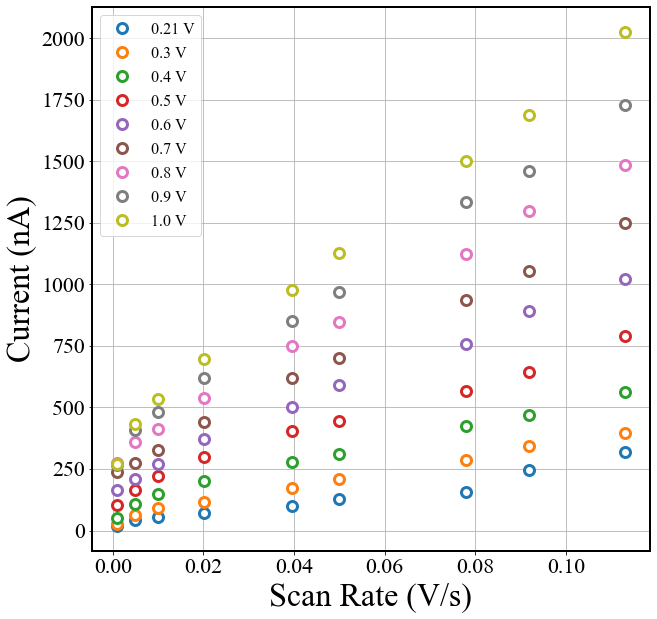

In [10]:
Sample = 13
Day = 2
Condition = 'hyd'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved
arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan

lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed

dvdt_current = Current_ScanRate_Auto (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
#print(type(dvdt_current.iloc[0][0]))

## Plot routine ##

plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Scan Rate (V/s)', fontproperties=font)
plt.ylabel('Current (nA)', fontproperties=font)
plt.grid(True)
for x in lista:
    plt.plot(dvdt_current['Scan_rate'], dvdt_current['I_{}'.format(x)].multiply(1e9),'o',
             markersize=10, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3, label = '{} V'.format(x))
plt.legend(prop={'family': 'Times New Roman','size': 16})

###!!! WARNING !!!# Remember to change the file name !!!!###

#plt.savefig(path+'S{}_{}_Current_ScanRate.png'.format(Sample, Condition), bbox_inches='tight')
plt.show();

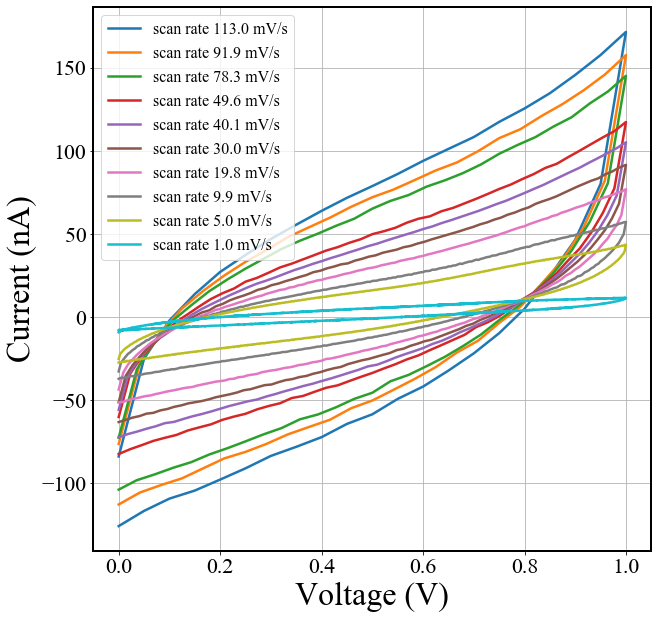

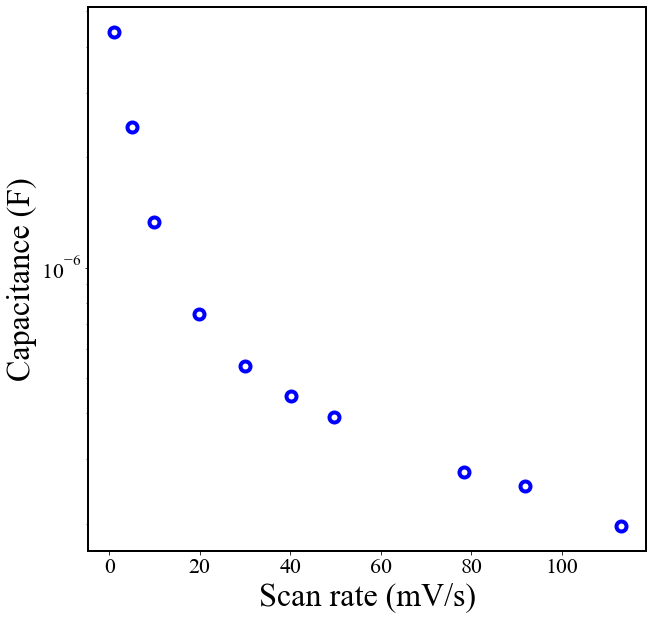

In [57]:
### Plot the third IV scan for several scan rates ###

Sample = 2
Day = 1
Condition = 'AP'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved


arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the name of the files from the third scan

dvdt = Calculate_dvdt(Path_Arq_Raw = path1, 
                      List_Arq = arq)
cap_dvdt_df = Capacitance (List_arq = arq,
                   Path_Arq_Raw = path1)
## Plot routine ##
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Voltage (V)', fontproperties=font)
plt.ylabel('Current (nA)', fontproperties=font)
plt.grid(True)

for x in range(len(arq)):
    file_aux= np.genfromtxt(path1+arq[x],skip_header=1) #ndarray with all the data from the element arq[x]
    leg = 'scan rate ' + str(round (dvdt[x]*1E3, 1)) + ' mV/s' # Defines the label rounding the dvdt mean
    plt.plot(file_aux[:,1], (file_aux[:,2])*1E9, linewidth=2.5, label=leg)
    plt.legend(prop={'family': 'Times New Roman','size': 16})

    #!!! WARNING !!!# Remember to change the file name !!!! #
plt.savefig(path+'S{}_IV_dielec-{}.png'.format(Sample, Condition),
            bbox_inches='tight')    
plt.show()

plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Scan rate (mV/s)', fontproperties=font)
plt.ylabel('Capacitance (F)', fontproperties=font)
plt.yscale('log')
plt.plot(cap_dvdt_df['Scan_Rate']*1E3, cap_dvdt_df['Capacitance'],'o', color = 'b',
             markersize=10, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=4)
plt.savefig(path+'S{}_Cap_SR-{}.png'.format(Sample, Condition),
            bbox_inches='tight')
cap_dvdt_df.to_excel(path+'S{}_Cap_SR-{}.xlsx'.format(Sample, Condition))
plt.show()

In [45]:
path

'D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE4\\DAY3\\'

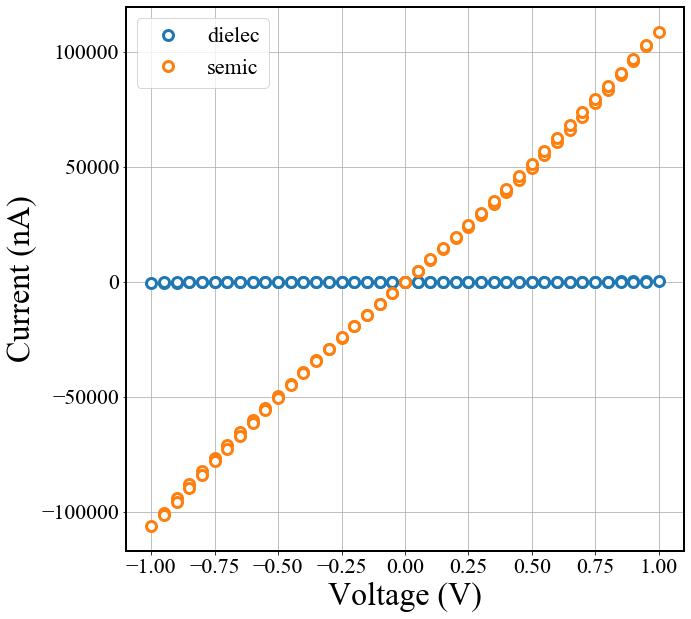

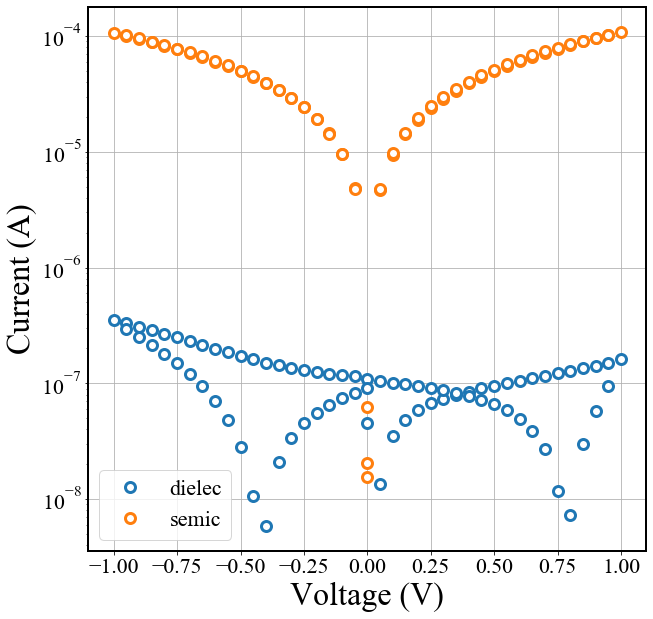

In [20]:
### Plot the comparison between dielec and semic directions ###

Sample = 13
Day = 1
Condition = 'AP'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved

arq = [x for x in os.listdir(path) if x.endswith("a0")] # Creates a list with the data to be compared.

## Plot routine ##
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Voltage (V)', fontproperties=font)
plt.ylabel('Current (nA)', fontproperties=font)
plt.grid(True)

## Linear plot
# \u03bc - for uA (micro Ampere)

for x in range(len(arq)):
    file_aux= np.genfromtxt(path+arq[x],skip_header=2) #ndarray with all the data from the element arq[x]
    leg = (arq[x]).split("-")[1] #split the file name to add to the label
    plt.plot(file_aux[:,1], (file_aux[:,2])*1E9, 'o',
         markersize=10, linewidth=4,
         markerfacecolor='white',
         markeredgewidth=3, label=leg)
    plt.legend(prop={'family': 'Times New Roman','size': 22})

    #!!! WARNING !!!# Remember to change the file name !!!!
    
plt.savefig(path+'S{}_IV_comp-{}_linear.png'.format(Sample, Condition), 
            bbox_inches='tight')
plt.show()
##

## Log scale plot
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Voltage (V)', fontproperties=font)
plt.ylabel('Current (A)', fontproperties=font)
plt.yscale('log')
plt.grid(True)

for x in range(len(arq)):
    file_aux= np.genfromtxt(path+arq[x],skip_header=2) #ndarray with all the data from the element arq[x]
    leg = (arq[x]).split("-")[1] #split the file name to add to the label
    plt.plot((file_aux[:,1]), (abs((file_aux[:,2]))),'o',
         markersize=10, linewidth=4,
         markerfacecolor='white',
         markeredgewidth=3, label=leg)
    plt.legend(prop={'family': 'Times New Roman','size': 22})

    #!!! WARNING !!!# Remember to change the file name !!!!
    
plt.savefig(path+'S{}_IV_comp-{}__log.png'.format(Sample, Condition),
            bbox_inches='tight')
plt.show()

0.4420776068206799 -14.6425726798281
0.9169937476797662
0.4374791204763254 -14.298460372312599
0.9537662458065199
0.4083294218146443 -14.012240621406333
0.9581505220933193
0.33450129365227904 -13.888146585534107
0.9381923066583187
0.3093469963947926 -13.686243154672617
0.8825830146396393
0.28531925366673455 -13.611028649185196
0.8358253199279592
0.27565355599427815 -13.506671028102287
0.8073853111608696
0.2638436819538406 -13.454332681928266
0.8007569687939932
0.2582925472153124 -13.368030737968255
0.8156909372481062


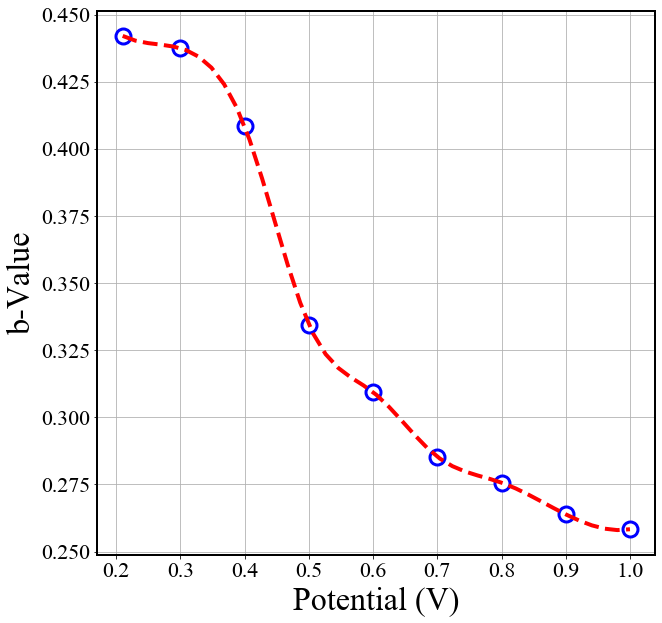

In [9]:
### Plot the b-values for a specific sample conditions for a range of voltages ###

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE7\\DAY2\\"
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved

arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan
lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed
b_value = [] #List of the b-values to be plotted

dvdt_current = Current_ScanRate (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
dvdt = dvdt_current[0]
current = dvdt_current[1]

for x in range(len(lista)):
    coef = (np.polyfit(np.log(dvdt[x,:]),np.log(current[x,:]),1))
    b_value.append(coef[0]) #Appends the b-value (angular coef) from the above linear regression
    print (coef[0],coef[1])
    correlation_matrix = np.corrcoef(np.log(dvdt[x,:]), np.log(abs(current[x,:])))
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    print(r_squared)

## Plotting routine ##
# Generation of a smooth eye-guide
xnew = np.linspace(0.21, 1, num=41, endpoint=True)
f_cubic = interp1d(lista, b_value, kind='cubic')
#
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Potential (V)', fontproperties=font)
plt.ylabel('b-Value', fontproperties=font)
plt.grid(True)
plt.plot(lista, b_value, 'o', color='red',
         markersize=15, linewidth=4,
         markerfacecolor='white',
         markeredgecolor='b',
         markeredgewidth=3)
plt.plot(xnew, f_cubic(xnew), '--', color='red',
         markersize=15, linewidth=4)
plt.savefig(path+'b-value.png', bbox_inches='tight') #!!! WARNING !!!# Remember to change the file name !!!!

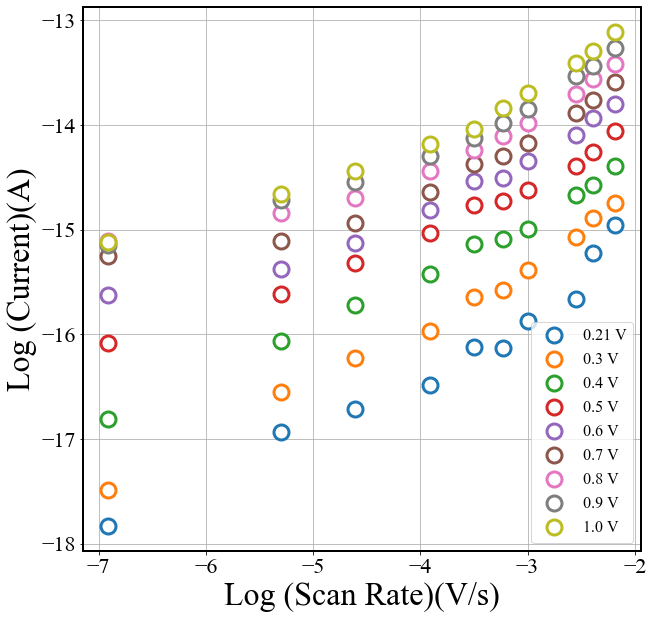

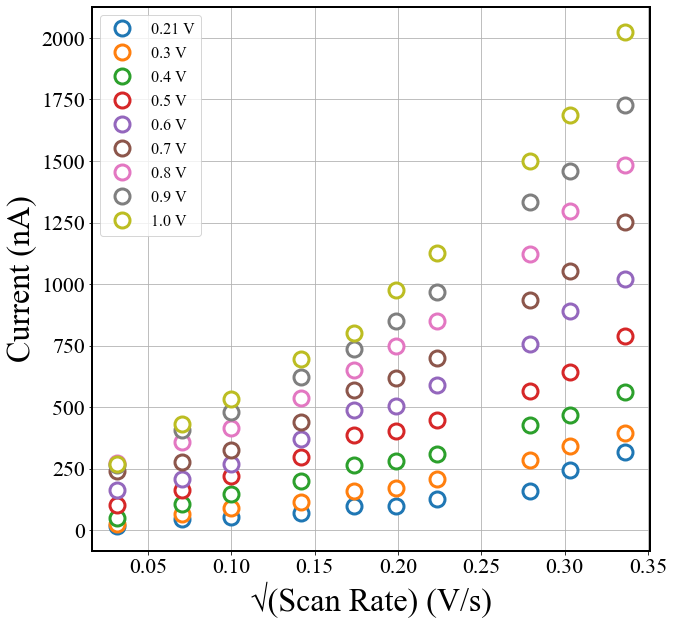

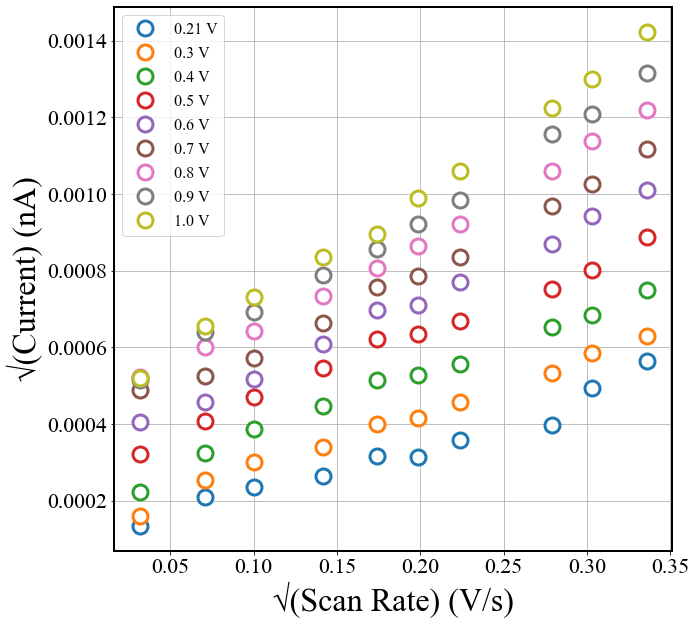

In [21]:
### Plotting ###

Sample = 13
Day = 2
Condition = 'hyd'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved
arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan

lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed

dvdt_current = Current_ScanRate_Auto (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
#print(type(dvdt_current.iloc[0][0]))

## Plot routine ##

#### Log_Log Plot ############################################################################################
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Log (Scan Rate)(V/s)', fontproperties=font)
plt.ylabel('Log (Current)(A)', fontproperties=font)
plt.grid(True)
for x in lista:
    plt.plot(np.log(dvdt_current['Scan_rate']), np.log(dvdt_current['I_{}'.format(x)]),'o',
             markersize=15, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3, label = '{} V'.format(x))
plt.legend(prop={'family': 'Times New Roman','size': 16})

###!!! WARNING !!!# Remember to change the file name !!!!###

plt.savefig(path+'S{}_{}_Current_ScanRate_Log.png'.format(Sample, Condition), bbox_inches='tight')
plt.show();

###############################################################################################################

#### Sqrt Scan Rate ##########################################################################################
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('\u221A(Scan Rate) (V/s)', fontproperties=font)
plt.ylabel('Current (nA)', fontproperties=font)
plt.grid(True)
for x in lista:
    plt.plot(np.power(dvdt_current['Scan_rate'], 0.5), (dvdt_current['I_{}'.format(x)].multiply(1E9)),'o',
             markersize=15, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3, label = '{} V'.format(x))
plt.legend(prop={'family': 'Times New Roman','size': 16})

###!!! WARNING !!!# Remember to change the file name !!!!###

plt.savefig(path+'S{}_{}_Current_ScanRate_Sqrt.png'.format(Sample, Condition), bbox_inches='tight')
plt.show();

###############################################################################################################

#### Sqrt Current & Scan Rate #################################################################################
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('\u221A(Scan Rate) (V/s)', fontproperties=font)
plt.ylabel('\u221A(Current) (nA)', fontproperties=font)
plt.grid(True)
for x in lista:
    plt.plot(np.power(dvdt_current['Scan_rate'], 0.5), np.power(dvdt_current['I_{}'.format(x)], 0.5),'o',
             markersize=15, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3, label = '{} V'.format(x))
plt.legend(prop={'family': 'Times New Roman','size': 16})

###!!! WARNING !!!# Remember to change the file name !!!!###

plt.savefig(path+'S{}_{}_Curr_ScanRate_Sqrt_vs_ScanRate_Sqrt.png'.format(Sample, Condition), bbox_inches='tight')
plt.show();

###############################################################################################################

In [22]:
dvdt_current

,Scan_rate,I_0.21,I_0.3,I_0.4,I_0.5,I_0.6,I_0.7,I_0.8,I_0.9,I_1.0
0,0.112897,3.194927e-07,3.964960e-07,5.620238e-07,7.892451e-07,1.021956e-06,1.250396e-06,1.485502e-06,1.728847e-06,2.024866e-06
1,0.091914,2.450360e-07,3.431374e-07,4.676954e-07,6.445438e-07,8.896005e-07,1.052012e-06,1.295893e-06,1.458532e-06,1.686892e-06
2,0.077941,1.578485e-07,2.850082e-07,4.265220e-07,5.651708e-07,7.571656e-07,9.359636e-07,1.123748e-06,1.335085e-06,1.500251e-06
3,0.050007,1.275771e-07,2.085006e-07,3.096785e-07,4.465966e-07,5.917115e-07,6.998116e-07,8.487349e-07,9.691720e-07,1.125659e-06
4,0.039543,9.894501e-08,1.728022e-07,2.799530e-07,4.030768e-07,5.030038e-07,6.180921e-07,7.476426e-07,8.510601e-07,9.775341e-07
5,0.030230,1.002907e-07,1.603344e-07,2.664105e-07,3.877017e-07,4.868015e-07,5.718169e-07,6.528322e-07,7.348168e-07,8.025128e-07
6,0.020031,6.958377e-08,1.159134e-07,2.009344e-07,2.968555e-07,3.704139e-07,4.387541e-07,5.372590e-07,6.213088e-07,6.966882e-07
7,0.010006,5.518093e-08,8.993049e-08,1.495676e-07,2.217295e-07,2.689311e-07,3.277041e-07,4.137463e-07,4.807202e-07,5.341940e-07
8,0.004982,4.433524e-08,6.504235e-08,1.059325e-07,1.657128e-07,2.096805e-07,2.756037e-07,3.606802e-07,4.085062e-07,4.309554e-07
9,0.000996,1.805144e-08,2.549326e-08,5.020830e-08,1.034199e-07,1.636545e-07,2.392139e-07,2.744078e-07,2.641110e-07,2.711764e-07


0.5563031400038111 -14.093571361980564
0.9492166500355829
0.5624812615825746 -13.634677746590633
0.9895249348902208
0.4981039520323853 -13.415733728817628
0.9939487454254412
0.423410385248009 -13.295599012210893
0.9795356394304721
0.40290565917598725 -13.097168205903081
0.9416660930763092
0.3666115342774344 -13.015114163737367
0.9031955045609861
0.3665774478849115 -12.816484606562277
0.9261925104791072
0.3963784563213778 -12.582970129202264
0.9567890664175268
0.4233354414519765 -12.368879415053021
0.9652471511459855


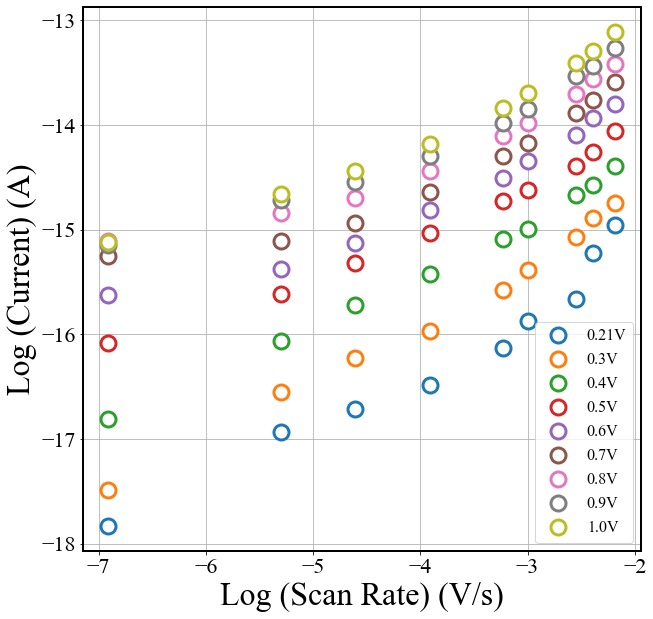

In [7]:
### Checking the linearity of the Log(I) vs Log(dvdt) ###

Sample = 13
Day = 2
Condition = 'hyd'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved
arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan

lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed

dvdt_current = Current_ScanRate (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
dvdt = dvdt_current[0]
current = dvdt_current[1]
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Log (Scan Rate) (V/s)', fontproperties=font)
plt.ylabel('Log (Current) (A)', fontproperties=font)
plt.grid(True)

for x in range(len(lista)):
    coef = (np.polyfit(np.log(dvdt[x,:]),np.log(current[x,:]),1))
    print (coef[0],coef[1])
    correlation_matrix = np.corrcoef(np.log(dvdt[x,:]), np.log(abs(current[x,:])))
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    print(r_squared)
    leg = str(lista[x]) + 'V'
    plt.plot(np.log(dvdt[x,:]),np.log(current[x,:]), 'o', label = leg,
             markersize=15, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3)
    plt.legend(prop={'family': 'Times New Roman','size': 16})
    
 
    ###!!! WARNING !!!# Remember to change the file name !!!!###

plt.savefig(path+'S{}_{}_Current_ScanRate_Log.png'.format(Sample, Condition), bbox_inches='tight')
plt.show()

In [8]:
### Plot Current vs. sqrt(Scan Rate) ###

Sample = 13
Day = 2
Condition = 'hyd'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved

arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan
lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed

dvdt_current = Current_ScanRate (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
dvdt = dvdt_current[0]
current = dvdt_current[1]

plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('\u221A(Scan Rate) (V/s)', fontproperties=font)
plt.ylabel('Current (\u03bcA)', fontproperties=font)
plt.grid(True)

for x in range(len(lista)):
    coef = (np.polyfit(np.power(dvdt[x,:],0.5),(current[x,:]),1))
    #print (coef[0],coef[1])
    Perc_Faradaic_Leakage (Linear_reg_parameters = coef
                           Voltage = lista[i])
    correlation_matrix = np.corrcoef(np.power(dvdt[x,:],0.5),(current[x,:]))
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    #print(r_squared)
    leg = str(lista[x]) + 'V'
    plt.plot(np.power(dvdt[x,:],0.5),(current[x,:])*1E6, 'o', label = leg,
             markersize=15, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3)
    plt.legend(prop={'family': 'Times New Roman','size': 16})
    
 
    ###!!! WARNING !!!# Remember to change the file name !!!!###

plt.savefig(path+'S{}_{}_Current_ScanRate_Sqrt.png'.format(Sample, Condition), bbox_inches='tight')
plt.show()

SyntaxError: invalid syntax (<ipython-input-8-848253fbab97>, line 31)

2.6098204140169843e-07 2.914459182716445e-08
0.9292789955067688
1.4579583191196743e-07 9.926696305210815e-08
0.628587484595966
8.593225394180869e-09 1.7465281818085704e-07
0.002749161590412261
-1.4020635797114448e-07 2.463330536595513e-07
0.24389033487077325
-2.9852382731173117e-07 3.245842624982236e-07
0.4285419917286763
-4.911237401102492e-07 4.109698811771073e-07
0.5739488006688441
-6.739389112888443e-07 5.052586765646634e-07
0.6766026649677592
-9.029445663461909e-07 6.137298387425148e-07
0.7799132907950648
-1.3230891193862423e-06 7.851431237485732e-07
0.8312723438678791


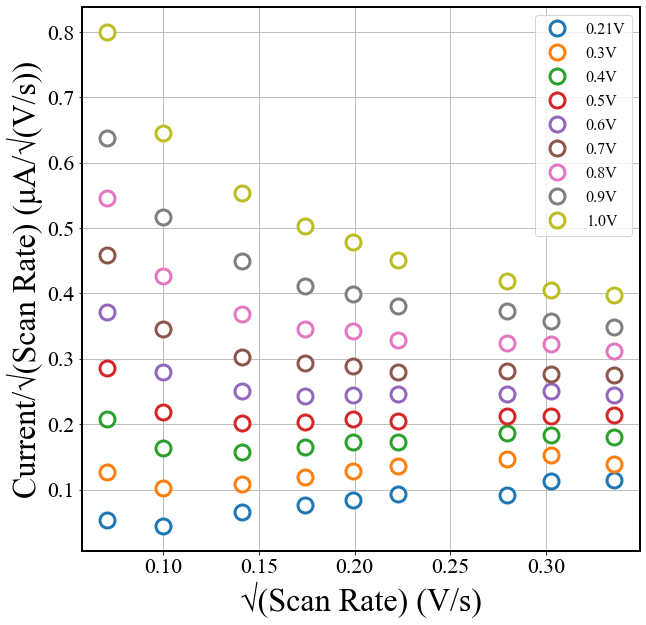

In [8]:
### Plot Current/sqrt(Scan Rate) vs. sqrt(Scan Rate) ###

Sample = 13
Day = 1
Condition = 'AP'

## Path is the location of the Sample number and day of experiment
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
path1 = path + "RAW\\" # This is the folder where the raw .dat data from each individual scan is saved

arq = [x for x in os.listdir(path1) if x.endswith("scan3")] # Creates a list with the data from the third IV scan
lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] # List of the voltages values to be analyzed

dvdt_current = Current_ScanRate (List_arq = arq,
                  List_Voltage_Values = lista, 
                  Path_Arq_Raw = path1)
dvdt = dvdt_current[0]
current = dvdt_current[1]

plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('\u221A(Scan Rate) (V/s)', fontproperties=font)
plt.ylabel('Current/\u221A(Scan Rate) (\u03bcA/\u221A(V/s))', fontproperties=font)
plt.grid(True)

for x in range(len(lista)):
    coef = (np.polyfit(np.power(dvdt[x,:-1],0.5),(current[x,:-1]/np.power(dvdt[x,:-1],0.5)),1))
    print (coef[0],coef[1])
    correlation_matrix = np.corrcoef(np.power(dvdt[x,:-1],0.5),(current[x,:-1]/np.power(dvdt[x,:-1],0.5)))
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    print(r_squared)
    leg = str(lista[x]) + 'V'
    plt.plot(np.power(dvdt[x,:-1],0.5),(current[x,:-1]*1E6/np.power(dvdt[x,:-1],0.5)), 'o', label = leg,
             markersize=15, linewidth=4,
             markerfacecolor='white',
             markeredgewidth=3)
    plt.legend(prop={'family': 'Times New Roman','size': 16})
    
 
    ###!!! WARNING !!!# Remember to change the file name !!!!###

plt.savefig(path+'S{}_{}_Curr_ScanRate_Sqrt_vs_ScanRate_Sqrt.png'.format(Sample, Condition), bbox_inches='tight')
plt.show()

[0.8283219164251002, 0.8444523568845317, 0.8975187589102264, 1.242359740398966, 1.4196155402211161, 1.7512038119430795, 2.41484865750502, 4.457424897988003, 8.548971208162925, 41.263352240949686]


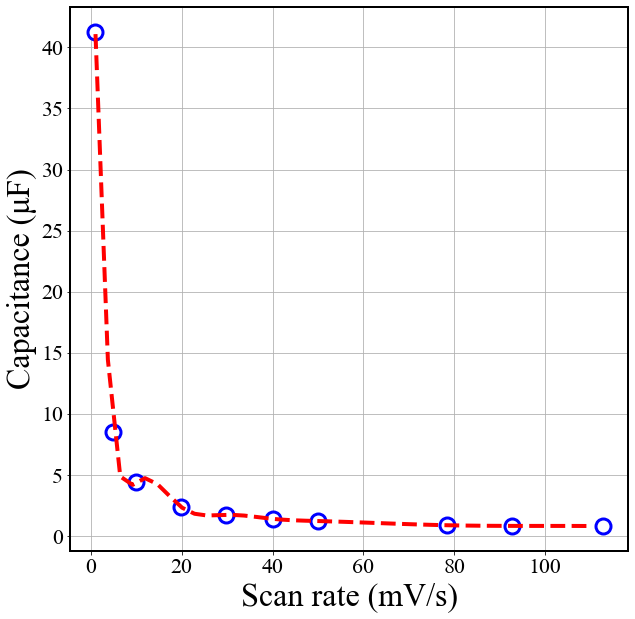

In [12]:
path_root = "D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\"
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE4\\DAY3\\"
path1 = path + "RAW\\"


arq = [x for x in os.listdir(path1) if x.endswith("scan3")]
arq_name = path_root+"Cap_vs_ScanRate_S3_hyd"
current_value = []
dvdt = []
#lista = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
cap = []


for x in range(len(arq)):
    file_aux= np.genfromtxt(path1+arq[x],skip_header=1)
    time = file_aux[:,0]
    voltage = file_aux[:,1]
    current = file_aux[:,2]
    dvdt_array = abs(np.diff(voltage) / np.diff(time))
    dvdt.append(np.average(dvdt_array[0:9]))
    range_var = (len(current)+1)/2
    #print(type(range_var), int(range_var))
    int_ida = np.trapz(current[0:int(range_var)], voltage[0:int(range_var)])
    int_volta = np.trapz(current[int(range_var)+1:], voltage[int(range_var)+1:])
    cap.append((int_ida - int_volta)/((dvdt[x])))
    
        
if os.path.isfile('./'+arq_name) == False:
    arq_aux = open(arq_name, 'a+')
    arq_aux.write('Scan Rate (V/s) \t Capacitance (F)\n')
arq_aux.close()

arq_aux = open(arq_name, 'a+')
for i in range(len(cap)):
    arq_aux.write(str(dvdt[i]) + '\t')
    arq_aux.write(str(cap[i]) + '\n')
arq_aux.close()

for i in range (len(cap)):
    dvdt[i] = dvdt[i]*1E3
    cap[i] = cap[i]*1E6
    
xnew = np.linspace(1, 110, num=41, endpoint=True)
f_cubic = interp1d(dvdt, cap, kind='cubic')
plt.figure(figsize=(10,10))
#plt.yscale('log')
#plt.xscale('log')
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Scan rate (mV/s)', fontproperties=font)
plt.ylabel('Capacitance (\u03bcF)', fontproperties=font)
plt.grid(True)
plt.plot(dvdt, cap, 'o', color='red',
         markersize=15, linewidth=4,
         markerfacecolor='white',
         markeredgecolor='b',
         markeredgewidth=3)
plt.plot(xnew, f_cubic(xnew), '--', color='red',
         markersize=15, linewidth=4)
plt.savefig(path+'cap_scan-rate.png', bbox_inches='tight')

print(cap)

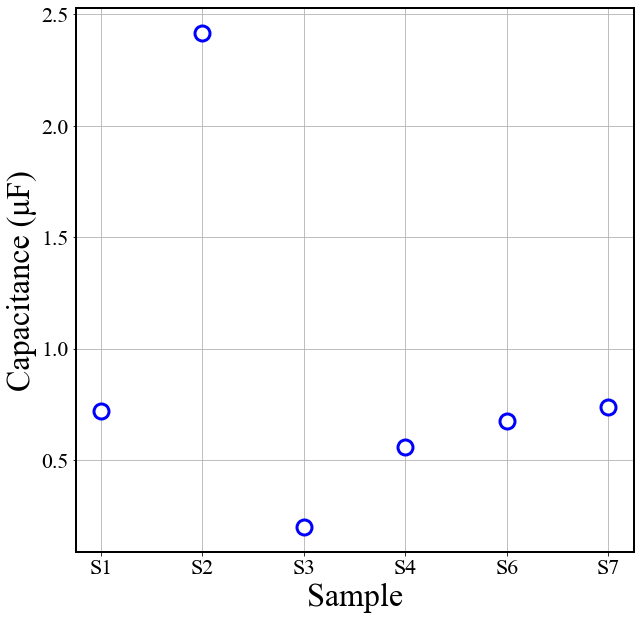

In [8]:
path_root ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\"

arq = [x for x in os.listdir(path_root) if x.endswith("AP")]
sample = ['S1','S2', 'S3', 'S4', 'S6', 'S7']
cap_aux = []

for x in range(len(arq)):
    file_aux= np.genfromtxt(path_root+arq[x],skip_header=1)
    #dvdt.append = file_aux[8,0]
    #print( [file_aux])
    cap_aux.append(file_aux[8,1]*1E6)
    
    
plt.figure(figsize=(10,10))
plt.yticks(fontproperties=font_tick)
plt.xticks(fontproperties=font_tick)
plt.xlabel('Sample', fontproperties=font)
plt.ylabel('Capacitance (\u03bcF)', fontproperties=font)
plt.grid(True)
plt.plot(sample, (cap_aux), 'o', color='red',
         markersize=15, linewidth=4,
         markerfacecolor='white',
         markeredgecolor='b',
         markeredgewidth=3)
plt.savefig(path_root+'capacitance_comp_10mV.png', bbox_inches='tight')    